# Software Defect Prediction
#### An Exploration of Model Interpretability in Software Defect Analysis

`Aidan Goodyer (goodyera@mcmaster.ca)` `Mason Azzopardi (azzoparm@mcmaster.ca)`


___

### Imports and Dataset Loading

In [12]:
%%capture
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install torch

In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import display, Markdown

df = pd.read_csv('dataset/dataset_csv/JM1.csv')

### Design Matrix and Label Construction, Standardization

We use ***z-score normalization*** to standardize our dataset so that we have a reliable scale to compare each metric against one and other.

Our design matrix is normalized as follows: 

$$ \phi(x) = \frac{x-\mu}{\sigma}$$

where:

$$ \mu = \frac{1}{n} \sum_{i=1}^n x_i \hspace{5mm} \sigma = \sqrt{ \frac{1}{n}\sum_{i=1}^n (x_i-\mu)^2} $$

with $x$ representing our individual raw features and the design matrix being the resulting matrix of $\phi(x)$ features.

In [14]:
columns_dropped = [
    'LOC_BLANK', 'LOC_TOTAL', 'LOC_CODE_AND_COMMENT', # proxies for LOC
]

df = df.drop(columns = columns_dropped)

raw_features = df.iloc[:, :-1].values.astype(float)

X_all = np.log1p(df.iloc[:, :-1].values.astype(float))
y_all = df.iloc[:,-1].apply(lambda x: 1 if str(x) == 'Y' else 0).values


X, X_test, y, y_test = train_test_split(X_all,y_all, test_size=0.20, random_state=123, stratify=y_all)

mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)

X = (X-mu)/sigma
X_test = (X_test-mu)/sigma



# Model

The Logistic Regression approach we employ is defined below. 

---

### Gradients



We base our model on the Gradient Descent for Logistic Regression Algorithm described in the Lecture Note.


The probability of the prensence of a defect in a module, $p(i)$ is calculated using sigmoid activation:

 $$  p(i) = \sigma( \theta^{t^\intercal} x^{(i)} + \theta_0) = \frac{1}{1+e^{- (\theta^{t^\intercal} x^{(i)} + \theta_0) }} $$


Since the consequences of missing a software defect are far more severe than investigating a few 'false alarm' cases, we introduce asymmetric weighting with a factor of 4 to prioritize the detection of defects. 

Let the weighted error term $e^{(i)}$ be: 


$$e^{(i)} = \begin{cases} 4(p^{(i)} - 1) & \text{if } y^{(i)} = 1 \\ p^{(i)} - 0 & \text{if } y^{(i)} = 0 \end{cases}$$


Then the gradients of our objective function are: 

$$\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)}) = \frac{1}{n} \sum_{i=1}^{n} e^{(i)} \mathbf{x}^{(i)} + \lambda \cdot \text{sign}(\boldsymbol{\theta}^{(t)})$$



$$\nabla_{\theta_0}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)}) = \frac{1}{n} \sum_{i=1}^{n} e^{(i)} $$


Note since we are using **L1** Regularization, we have adjusted the gradient of the $\lambda$ term to be $\text{sign}(\boldsymbol{\theta}^{(t)})$ since $\frac{d}{dx} \left|x\right| = \text{sign}(x) $ 


---
### Update Rule 



Using these gradients, our update rule becomes: 

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \eta \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)})$$

$$\theta_0^{(t+1)} = \theta_0^{(t)} - \eta \nabla_{\theta_0}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)})$$


---

The following python code implements the equations defined above:

In [15]:
n, d = X.shape
eta = 0.1
theta = np.zeros(d)
theta_zero = 0 
l1_reg = 0.02
epochs = 1000

accuracy_v = [] # store accuracy 

def sigmoid(x):
    return 1/(1+np.exp(-x))

for i in range(epochs):
    z = np.dot(X,theta) + theta_zero
    p = sigmoid(z)

    predictions = (p>=0.5).astype(int)
    accuracy = np.mean(predictions==y)
    accuracy_v.append(accuracy)

    error = p-y
    asymmetric_error = np.where(y==1, error*4, error)

    d_theta = (1/n)*np.dot(X.T, asymmetric_error) + l1_reg*np.sign(theta)
    d_theta_zero = (1/n)*np.sum(asymmetric_error)

    theta -= eta*d_theta
    theta_zero -= eta*d_theta_zero

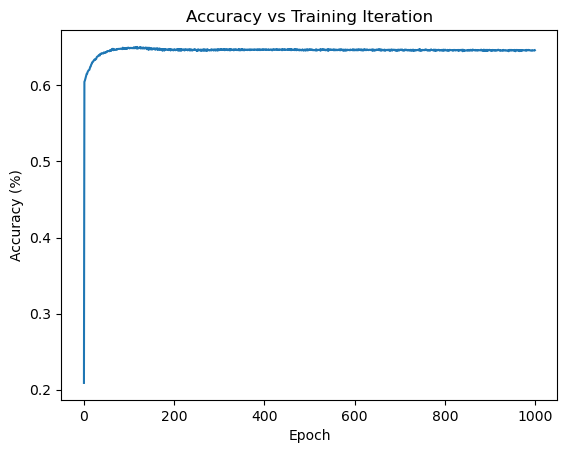

In [16]:
# Plot Accuracy
plt.plot(accuracy_v, label='Training Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy vs Training Iteration')
plt.show()

## Results Analysis
--- 

#### Confusion Matrices: 

In [17]:
# ~~~~~~~~~~~~~~ Training Set Results ~~~~~~~~~~~~~~

true_positives = np.sum( (predictions==1) & (y==1))
true_negatives = np.sum( (predictions==0) & (y==0))
false_positives = np.sum( (predictions==1) & (y==0))
false_negatives = np.sum( (predictions==0) & (y==1))

md_table = '### Confusion Matrix: Training Set\n'
md_table += '| | Predicted: Correct (0) | Predicted: Defect (1) |\n'
md_table += '| :--- | :---: | :---: |\n'
md_table += f'| **Actual: Clean (0)** | {true_negatives} (True Negative) | {false_positives} (False Positive) |\n'
md_table += f'| **Actual: Buggy (1)** | {false_negatives} (False Negative) | {true_positives} (True Positive) |\n'
display(Markdown(md_table))

# ~~~~~~~~~~~~~~ Test Set Results ~~~~~~~~~~~~~~

z_test = np.dot(X_test,theta) + theta_zero
p_test = sigmoid(z_test)
y_pred = (p_test >= 0.5).astype(int)


true_positives_test = np.sum( (y_pred==1) & (y_test==1))
true_negatives_test  = np.sum( (y_pred==0) & (y_test==0))
false_positives_test  = np.sum( (y_pred==1) & (y_test==0))
false_negatives_test  = np.sum( (y_pred==0) & (y_test==1))

md_table = '### Confusion Matrix: Test Set\n'
md_table += '| | Predicted: Correct (0) | Predicted: Defect (1) |\n'
md_table += '| :--- | :---: | :---: |\n'
md_table += f'| **Actual: Clean (0)** | {true_negatives_test} (True Negative) | {false_positives_test} (False Positive) |\n'
md_table += f'| **Actual: Buggy (1)** | {false_negatives_test} (False Negative) | {true_positives_test} (True Positive) |\n'


display(Markdown(md_table))

### Confusion Matrix: Training Set
| | Predicted: Correct (0) | Predicted: Defect (1) |
| :--- | :---: | :---: |
| **Actual: Clean (0)** | 3186 (True Negative) | 1700 (False Positive) |
| **Actual: Buggy (1)** | 485 (False Negative) | 805 (True Positive) |


### Confusion Matrix: Test Set
| | Predicted: Correct (0) | Predicted: Defect (1) |
| :--- | :---: | :---: |
| **Actual: Clean (0)** | 787 (True Negative) | 435 (False Positive) |
| **Actual: Buggy (1)** | 110 (False Negative) | 212 (True Positive) |


### Feature Importance for Defect Prediction 
Metric Name | Weight Magnitude | Impact 
 | :--- | :--- | :--- 
| NUM_UNIQUE_OPERANDS | 0.2456 | ⬆ Probability
| LOC_EXECUTABLE | 0.1657 | ⬆ Probability
| LOC_COMMENTS | 0.0970 | ⬆ Probability
| DESIGN_COMPLEXITY | 0.0709 | ⬆ Probability
| CYCLOMATIC_COMPLEXITY | 0.0679 | ⬆ Probability
| HALSTEAD_ERROR_EST | 0.0393 | ⬆ Probability
| NUM_OPERANDS | 0.0013 | ✖ Little Impact
| HALSTEAD_EFFORT | 0.0012 | ✖ Little Impact
| HALSTEAD_LEVEL | 0.0011 | ✖ Little Impact
| HALSTEAD_PROG_TIME | 0.0009 | ✖ Little Impact
| ESSENTIAL_COMPLEXITY | 0.0008 | ✖ Little Impact
| HALSTEAD_LENGTH | 0.0007 | ✖ Little Impact
| NUM_UNIQUE_OPERATORS | 0.0007 | ✖ Little Impact
| NUM_OPERATORS | 0.0003 | ✖ Little Impact
| BRANCH_COUNT | 0.0002 | ✖ Little Impact
| HALSTEAD_VOLUME | 0.0001 | ✖ Little Impact
| HALSTEAD_CONTENT | 0.0001 | ✖ Little Impact
| HALSTEAD_DIFFICULTY | 0.0001 | ✖ Little Impact


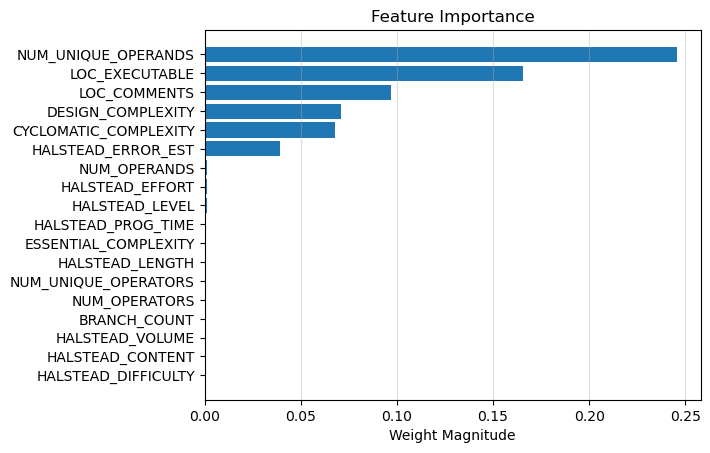

In [18]:
md_table = '### Feature Importance for Defect Prediction \n'
md_table += 'Metric Name | Weight Magnitude | Impact \n'
md_table += ' | :--- | :--- | :--- \n'

feature_names = df.columns[:-1]
importance = sorted(list(zip(feature_names,abs(theta),np.sign(theta))), key=lambda x: abs(x[1]), reverse=True)

for name, weight, sign in importance :

    impact = '✖ Little Impact' if (weight < 1e-2) else ('⬆ Probability' if sign>0 else '⬇ Probability')
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))


names = [name for name, _, _ in importance]
weight = [ weight for _, weight, _ in importance]


plt.title('Feature Importance')
plt.xlabel("Weight Magnitude")
plt.grid(axis='x', alpha=0.4)
plt.barh(names[::-1],weight[::-1])
plt.show()



# GHRP Dataset

## Preprocessing

In [19]:
df = pd.read_csv('dataset/GHRP_dataset_csv/baseline.csv')
raw_features = df.iloc[:, 1:-1].values.astype(float)
y = df.iloc[:,-1].values
test_size = 0.2
x_train, x_test,y_train,y_test = train_test_split(raw_features,y,test_size=test_size,random_state=42,stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## Log Regression

### Model 

In [20]:
#given the difference in the data formatting we have to redefine these functions
def sigmoid(z):
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))


def train_model(X,y,learning_rate,theta,theta_zero,epochs,reg):
    n, d = X.shape
    y = y.reshape(-1,1)
    

    for i in range(epochs):
        z = np.dot(X,theta) + theta_zero
        p = sigmoid(z)

        error = p-y


        d_theta = (1/n)*np.dot(X.T, error) + reg*np.sign(theta)
        d_theta_zero = (1/n)*np.sum(p-y)

        theta -= learning_rate*d_theta
        theta_zero -= learning_rate*d_theta_zero
    return theta, theta_zero


### Training

In [21]:
n, d = X_train.shape

eta = 0.2
theta = np.zeros(d).reshape(-1,1)
theta_zero = 0 
l1_reg = 0.001
epochs = 50000

theta,theta_zero = train_model(X_train,y_train,eta,theta,theta_zero,epochs,l1_reg)

### Results

In [22]:
def calculate_accuracy(X_test,y_test,theta,theta_zero):
    z = np.dot(X_test,theta) + theta_zero
    y_test=y_test.reshape(-1,1)
    predictions = (sigmoid(z)>=0.5)
    accuracy = (predictions==y_test).mean()



    return accuracy,predictions

In [23]:
accuracy,predictions = calculate_accuracy(X_test,y_test,theta,theta_zero)
print("Accuracy:", round(accuracy*100,2),"%") 

Accuracy: 71.68 %


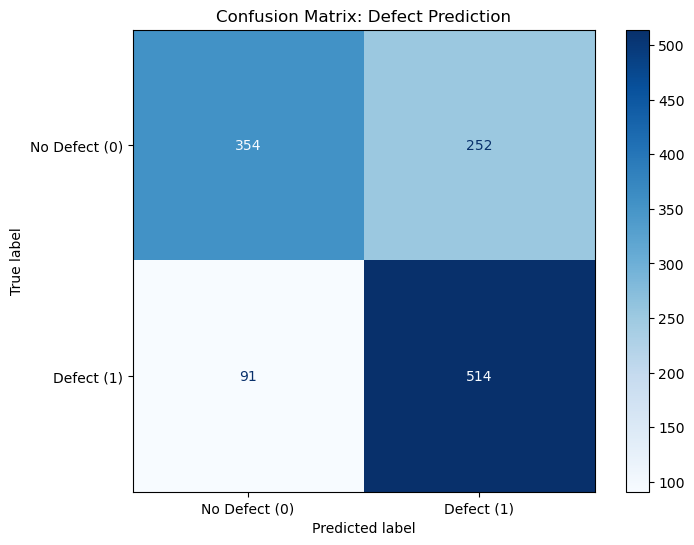

In [24]:
cm = sklearn.metrics.confusion_matrix(y_test, predictions, labels=[0, 1])

# 3. Plot the Matrix
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Defect (0)', 'Defect (1)'])

# Plot with a custom size and colormap
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Defect Prediction')
plt.show()

### Feature Importance for Defect Prediction 
Metric Name | Weight Magnitude | Impact 
 | :--- | :--- | :--- 
| nosi | 2.1487 | ⬇ Probability
| dit | 0.5788 | ⬇ Probability
| cbo | 0.5759 | ⬆ Probability
| rfc | 0.3825 | ⬇ Probability
| loc | 0.2674 | ⬆ Probability
| returnQty | 0.2404 | ⬆ Probability
| lcom | 0.1813 | ⬇ Probability
| mathOperationsQty | 0.1390 | ⬆ Probability
| maxNestedBlocks | 0.1297 | ⬆ Probability
| comparisonsQty | 0.1032 | ⬇ Probability
| stringLiteralsQty | 0.0565 | ⬆ Probability
| tryCatchQty | 0.0415 | ⬆ Probability
| parenthesizedExpsQty | 0.0372 | ⬆ Probability
| numbersQty | 0.0352 | ⬆ Probability
| totalMethods | 0.0279 | ⬇ Probability
| uniqueWordsQty | 0.0258 | ⬆ Probability
| variablesQty | 0.0197 | ⬆ Probability
| totalFields | 0.0101 | ⬇ Probability
| loopQty | 0.0002 | ✖ Little Impact
| wmc | 0.0001 | ✖ Little Impact
| assignmentsQty | 0.0001 | ✖ Little Impact


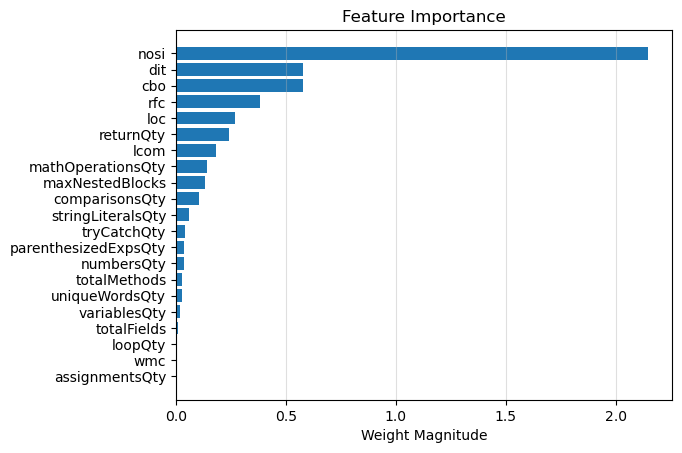

In [42]:
from IPython.display import display, Markdown


theta_flat = theta.flatten()

md_table = '### Feature Importance for Defect Prediction \n'
md_table += 'Metric Name | Weight Magnitude | Impact \n'
md_table += ' | :--- | :--- | :--- \n'

feature_names = df.columns[1:-1]


importance = sorted(list(zip(feature_names, abs(theta_flat), np.sign(theta_flat))), key=lambda x: abs(x[1]), reverse=True)

for name, weight, sign in importance :

    impact = '✖ Little Impact' if (weight < 1e-3) else ('⬆ Probability' if sign>0 else '⬇ Probability')
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))

names = [name for name, _, _ in importance]
weight = [ weight for _, weight, _ in importance]


plt.title('Feature Importance')
plt.xlabel("Weight Magnitude")
plt.grid(axis='x', alpha=0.4)
plt.barh(names[::-1],weight[::-1])
plt.show()


## Fully Connected Neural Network

In [26]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle

### Preprocessing

In [27]:


X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_test)


print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")

Training features shape: torch.Size([4841, 21])
Validation features shape: torch.Size([1211, 21])


### Model

In [28]:
class Net(nn.Module):

    def __init__(self, input_size,dropout_rate):
        super(Net, self).__init__()
        self.dropout_rate = dropout_rate
        self.input_size = input_size

        self.fc1 = nn.Linear(self.input_size, 32)

        self.fc2 = nn.Linear(32, 16)

        self.fc3 = nn.Linear(16,1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        


    def forward(self, x):

        l1 = self.fc1(x)
        r1 = self.relu(l1)
        d1 = self.dropout(r1)


        l2 = self.fc2(d1)
        r2 = self.relu(l2)
        d2 = self.dropout(r2)
   

        l3 = self.fc3(d2)
        output = self.sigmoid(l3)


        
        return output
    
input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")

Model will accept 21 input features.
--- 3. Model Class Defined ---


### Training

In [29]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, l1_lambda):

    num_samples = X_train.shape[0]
    current_iteration = 0
    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    
    for i in range(num_iterations):
        if current_iteration+batch_size > num_samples:
            
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy())
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_iteration = 0 
        
        
        xt_batch = X_train_shuffled[current_iteration : current_iteration+ batch_size]
        yt_batch = y_train_shuffled[current_iteration : current_iteration+ batch_size]

        current_iteration+=batch_size
        l1_norm = sum(p.abs().sum() for p in model.parameters())

        model.train()
        optimizer.zero_grad()
        t_pred = model(xt_batch)
        t_loss = criterion(t_pred,yt_batch) + l1_lambda*l1_norm
        t_loss.backward()
        optimizer.step()


    return model 

In [30]:
dropout_rate=0.5
LAMBDA_L1= 0.001
LEARNING_RATE_L1 = 0.01
NUM_ITERATIONS_L1 = 100000
BATCH_SIZE_L1 = 64
y_train_t = torch.tensor(y_train).view(-1,1).float()
y_val_t = torch.tensor(y_test).view(-1,1).float()

model_l1 = Net(input_size=input_features,dropout_rate=dropout_rate)
criterion = nn.BCELoss()
optimizer_l1 =  torch.optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L1)


model= train_with_minibatch(
    model_l1, criterion, optimizer_l1,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_L1, BATCH_SIZE_L1, LAMBDA_L1
)



### Results

In [31]:

def calculate_accuracy_nn(model, X, y):

    model.eval()
    with torch.no_grad():

        outputs = model(X) 
        predictions = (outputs>=0.5).float() 
        accuracy = (predictions == y).float().mean() 


    return accuracy,predictions

In [44]:
final_accuracy_l1,predictions = calculate_accuracy_nn(model,X_val_t,y_val_t)
print(f"Final Accuracy: {final_accuracy_l1*100:.2f}%")

Final Accuracy: 75.64%


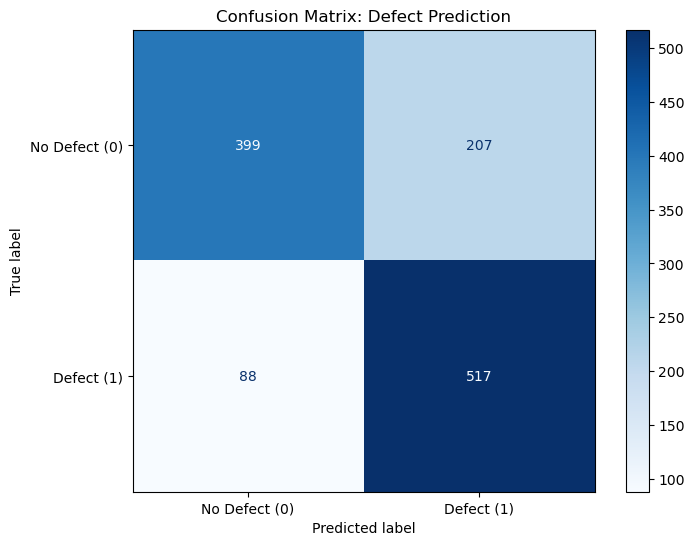

In [33]:
cm = sklearn.metrics.confusion_matrix(y_val_t, predictions, labels=[0, 1])

# 3. Plot the Matrix
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Defect (0)', 'Defect (1)'])

# Plot with a custom size and colormap
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Defect Prediction')

plt.show()

#### ***Sparsity Representation***
We chose to represent the sparsity of our neural network via the normalized sum of the first layer weights relevent to each input metric
- $w_{j,i}$ represents the *i*th weight of the *j*th input
- $s_j$ represents the sum of the weights of the *j*th input
$$s_j = \sum_{i=1}^n w_{j,i}$$
$$ W = \sum_{i=1,j=1}^{n,m}w_{j,i}$$
$$ns_j = \frac{s_j}{W}$$

**Essentailly we are representing the importance of each feature by their contribution to the total weight of the first layer**
   

### Feature Importance (L1 Sparsity Check) 
Metric Name | Standardized Weight Magnitude | Status 
 | :--- | :--- | :--- 
| nosi | 0.7553 | Active Feature
| dit | 0.0549 | Active Feature
| cbo | 0.0420 | Active Feature
| loc | 0.0371 | Active Feature
| rfc | 0.0162 | Active Feature
| comparisonsQty | 0.0138 | Active Feature
| mathOperationsQty | 0.0119 | Active Feature
| numbersQty | 0.0103 | Active Feature
| maxNestedBlocks | 0.0093 | Pruned (Little Impact)
| totalMethods | 0.0081 | Pruned (Little Impact)
| returnQty | 0.0069 | Pruned (Little Impact)
| loopQty | 0.0061 | Pruned (Little Impact)
| stringLiteralsQty | 0.0041 | Pruned (Little Impact)
| parenthesizedExpsQty | 0.0040 | Pruned (Little Impact)
| variablesQty | 0.0037 | Pruned (Little Impact)
| uniqueWordsQty | 0.0034 | Pruned (Little Impact)
| tryCatchQty | 0.0033 | Pruned (Little Impact)
| assignmentsQty | 0.0032 | Pruned (Little Impact)
| totalFields | 0.0031 | Pruned (Little Impact)
| wmc | 0.0021 | Pruned (Little Impact)
| lcom | 0.0010 | Pruned (Little Impact)


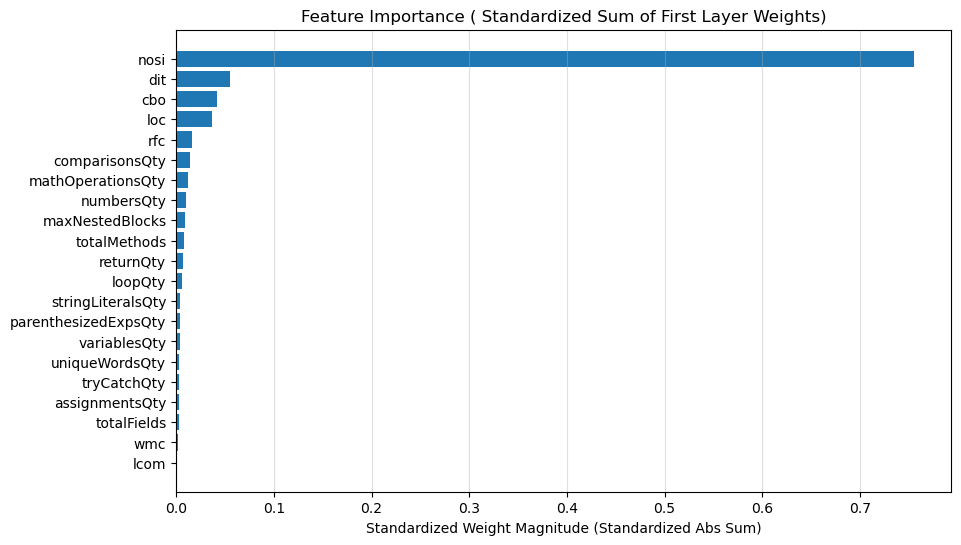

In [ ]:
from IPython.display import display, Markdown


first_layer_weights = next(model.parameters()).data.cpu()


weights = torch.sum(torch.abs(first_layer_weights), dim=0).numpy()

standard_weights = weights/(sum(weights)+1e-9)
feature_names = df.columns[1:-1] 


importance = sorted(list(zip(feature_names, standard_weights)), key=lambda x: x[1], reverse=True)


md_table = '### Feature Importance (L1 Sparsity Check) \n'
md_table += 'Metric Name | Standardized Weight Magnitude | Status \n'
md_table += ' | :--- | :--- | :--- \n'

for name, weight in importance:

    
    if weight < 1e-2:
        impact = 'Pruned (Little Impact)' 
    else:
        impact = 'Active Feature'
        
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))

names_sorted = [name for name, _ in importance]
weights_sorted = [weight for _, weight in importance]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance ( Standardized Sum of First Layer Weights)')
plt.xlabel("Standardized Weight Magnitude (Standardized Abs Sum)")
plt.grid(axis='x', alpha=0.4)


top_n = 30 
plt.barh(names_sorted[:top_n][::-1], weights_sorted[:top_n][::-1])
plt.show()